In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt




In [3]:
def query_db(query):
    conn = sqlite3.connect('../data/bundesliga3.db')
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

In [5]:
squad_map = pd.read_csv('../data/processed/squads_map_performance.csv')
squad_map.head()

df_standings = query_db("SELECT * FROM standings")

df_playerStats = query_db("SELECT * FROM playerStats")

df_transfers = query_db('''SELECT * FROM transfers''')

In [19]:
df_2023_transfers = df_transfers[df_transfers['season_id'] == 2023]
df_2023_transfers.head()

,Unnamed: 0,transfer_id,transfer_date,transfer_type,season,season_id,player_id,player_name,player_age_at_transfer,transfer_fee_euro,...,to_club_name,to_competition_id,to_competition_name,date_of_birth_datetime,citizenship,position.main,position.other,height_cm,foot,updated_at
2226,2226,4446014,01/07/2023,paid transfer,23/24,2023,344381,Christopher Nkunku,25.0,60000000.0,...,Chelsea,GB1,Premier League,14/11/1997,['France' 'DR Congo'],Attacking Midfield,['Second Striker' 'Left Winger'],177.0,right,2024-02-24T18:47:08.352079
2227,2227,4451491,01/07/2023,paid transfer,23/24,2023,242063,Vaclav Cerny,25.0,8000000.0,...,VfL Wolfsburg,L1,Bundesliga,17/10/1997,['Czech Republic'],Right Winger,['Left Winger'],182.0,left,2024-02-24T08:39:52.565472
2228,2228,4433385,01/07/2023,paid transfer,23/24,2023,232418,Ondrej Duda,28.0,2700000.0,...,Hellas Verona,IT1,Serie A,05/12/1994,['Slovakia'],Central Midfield,['Attacking Midfield'],180.0,right,2024-02-24T10:27:10.084035
2229,2229,4418720,01/07/2023,None,23/24,2023,656250,Marcel Lubik,19.0,NaN,...,FC Augsburg,L1,Bundesliga,19/05/2004,['Poland' 'Germany'],Goalkeeper,None,190.0,left,2024-02-26T17:27:32.832987
2230,2230,4419288,01/07/2023,None,23/24,2023,147573,Sebastian Andersson,31.0,NaN,...,Without Club,None,None,15/07/1991,['Sweden'],Centre-Forward,None,190.0,right,2024-02-24T12:36:53.075987


In [7]:
df_playerStats.columns

Index(['Rk', 'season_id_x', 'competition_id', 'Player', 'Nation', 'Pos',
       'Squad', 'Age', 'Born', 'MP', 'Starts', 'Min', '90s', 'PrgP', 'xG_90',
       'xAG_90', 'xG_xAG', 'Gls', 'Sh', 'Cmp', 'Touches', 'PrP_Cmp_100',
       'Sh_Tch_100', 'season', 'club_name', 'club_id', 'League_Position',
       'season_id_y'],
      dtype='object')

In [8]:
df = df_playerStats
#calculate team total xg and xag
club_totals = df.groupby('club_id')[['xG_90', 'xAG_90']].sum().reset_index()
club_totals.rename(columns={'xG_90': 'team_xG', 'xAG_90': 'team_xAG'}, inplace=True)
df = df.merge(club_totals, on='club_id', how='left')

#Calculate the percentage contribution of each player's to team total
df['xG_pct_of_team'] = (df['xG_90'] / df['team_xG']) * 100
df['xAG_pct_of_team'] = (df['xAG_90'] / df['team_xAG']) * 100

#Filter Only players more than 1000minutes play time
df = df[df['Min'] >= 1000]

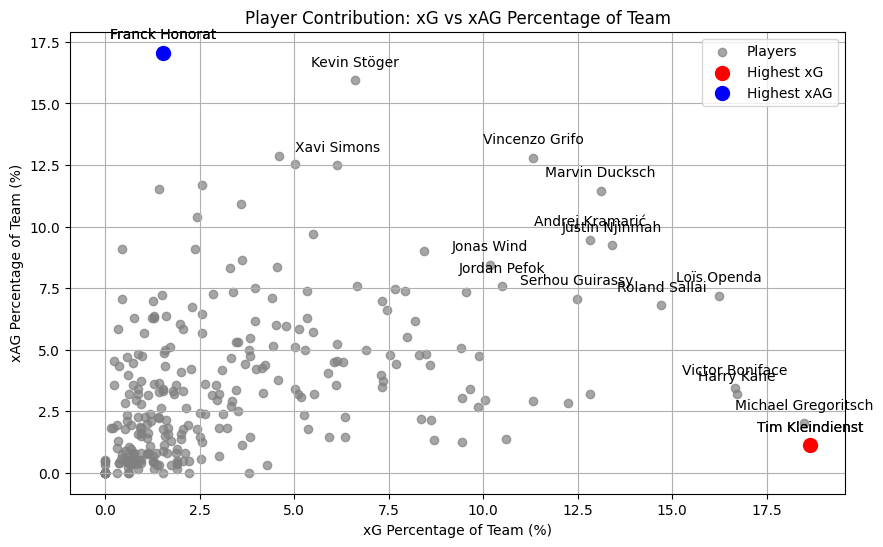

In [9]:
#Filter Only players more than 1000minutes play time
df = df[df['Min'] >= 1000]

max_xg_player = df.loc[df['xG_pct_of_team'].idxmax()]
max_xag_player = df.loc[df['xAG_pct_of_team'].idxmax()]

plt.figure(figsize=(10, 6))
plt.scatter(df['xG_pct_of_team'], df['xAG_pct_of_team'], color='grey', alpha=0.7, label='Players')
plt.scatter(max_xg_player['xG_pct_of_team'], max_xg_player['xAG_pct_of_team'], color='red', s=100, label='Highest xG')
plt.annotate(max_xg_player['Player'], 
             (max_xg_player['xG_pct_of_team'], max_xg_player['xAG_pct_of_team']),
             textcoords="offset points", xytext=(0,10), ha='center')
plt.scatter(max_xag_player['xG_pct_of_team'], max_xag_player['xAG_pct_of_team'], color='blue', s=100, label='Highest xAG')
plt.annotate(max_xag_player['Player'], 
             (max_xag_player['xG_pct_of_team'], max_xag_player['xAG_pct_of_team']),
             textcoords="offset points", xytext=(0,10), ha='center')

high_contributors = df[df['xG_pct_of_team'] + df['xAG_pct_of_team'] > 18]

for i, row in high_contributors.iterrows():
    plt.annotate(row['Player'], 
                 (row['xG_pct_of_team'], row['xAG_pct_of_team']),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('xG Percentage of Team (%)')
plt.ylabel('xAG Percentage of Team (%)')
plt.title('Player Contribution: xG vs xAG Percentage of Team')
plt.legend()
plt.grid(True)
plt.show()



In [10]:
df.columns
df_player_transfers = pd.merge(df, df_transfers, left_on=['Player','season_id_x'], right_on=['player_name','season_id'], how='outer')
df_player_transfers.columns

Index(['Rk', 'season_id_x', 'competition_id', 'Player', 'Nation', 'Pos',
       'Squad', 'Age', 'Born', 'MP', 'Starts', 'Min', '90s', 'PrgP', 'xG_90',
       'xAG_90', 'xG_xAG', 'Gls', 'Sh', 'Cmp', 'Touches', 'PrP_Cmp_100',
       'Sh_Tch_100', 'season_x', 'club_name', 'club_id', 'League_Position',
       'season_id_y', 'team_xG', 'team_xAG', 'xG_pct_of_team',
       'xAG_pct_of_team', 'Unnamed: 0', 'transfer_id', 'transfer_date',
       'transfer_type', 'season_y', 'season_id', 'player_id', 'player_name',
       'player_age_at_transfer', 'transfer_fee_euro', 'transfer_fee_million',
       'market_value_euro', 'market_value_million', 'from_club_id',
       'from_club_name', 'from_competition_id', 'from_competition_name',
       'to_club_id', 'to_club_name', 'to_competition_id',
       'to_competition_name', 'date_of_birth_datetime', 'citizenship',
       'position.main', 'position.other', 'height_cm', 'foot', 'updated_at'],
      dtype='object')

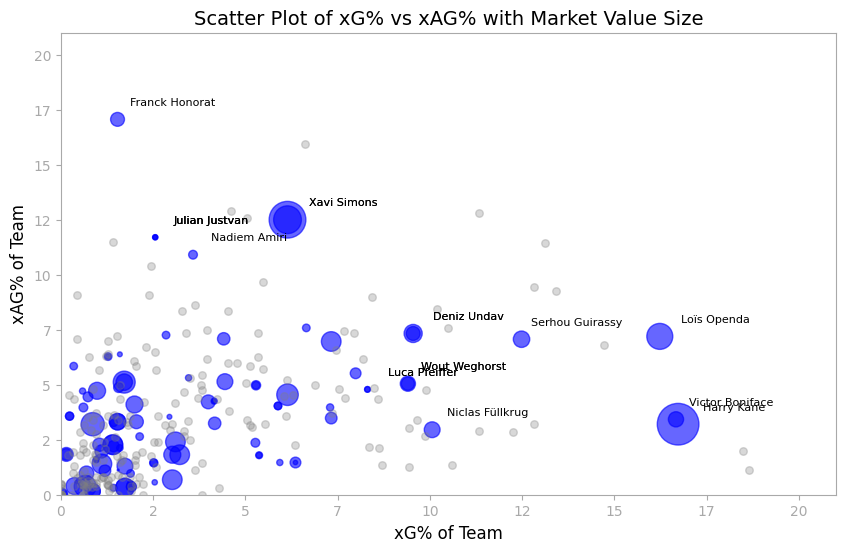

In [12]:

plt.figure(figsize=(10, 6))

# Players with market value
mask_with_value = df_player_transfers['market_value_million'].notna()
plt.scatter(
    df_player_transfers.loc[mask_with_value, 'xG_pct_of_team'], 
    df_player_transfers.loc[mask_with_value, 'xAG_pct_of_team'], 
    s=df_player_transfers.loc[mask_with_value, 'market_value_million'] * 10,  
    alpha=0.6, 
    c='blue', 
    label='Market Value Players'
)

# Players without market value
mask_without_value = df_player_transfers['market_value_million'].isna()
plt.scatter(
    df_player_transfers.loc[mask_without_value, 'xG_pct_of_team'], 
    df_player_transfers.loc[mask_without_value, 'xAG_pct_of_team'], 
    s=30,  
    color='grey', 
    alpha=0.3, 
    label='No Market Value Players'
)

# Adding labels and title
plt.title('Scatter Plot of xG% vs xAG% with Market Value Size', fontsize=14)
plt.xlabel('xG% of Team', fontsize=12)
plt.ylabel('xAG% of Team', fontsize=12)

# Add player name labels for those with xAG > 10 or xG > 8
for i, row in df_player_transfers.iterrows():
    if (row['xAG_pct_of_team'] > 10 or row['xG_pct_of_team'] > 8) and pd.notna(row['player_name']):
        plt.annotate(
            row['player_name'], 
            (row['xG_pct_of_team'], row['xAG_pct_of_team']),
            textcoords="offset points", 
            xytext=(40, 10),  
            ha='center',
            fontsize=8
        )

# Set limits
plt.ylim(0, 21)
plt.xlim(0, 21)

# Change color of the axes and labels
plt.gca().spines['top'].set_color('darkgrey')
plt.gca().spines['right'].set_color('darkgrey')
plt.gca().spines['left'].set_color('darkgrey')
plt.gca().spines['bottom'].set_color('darkgrey')
plt.gca().tick_params(axis='both', colors='darkgrey')

# Remove decimal points on axes
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}'))

# Show legend
#plt.legend()

# Show plot
plt.show()


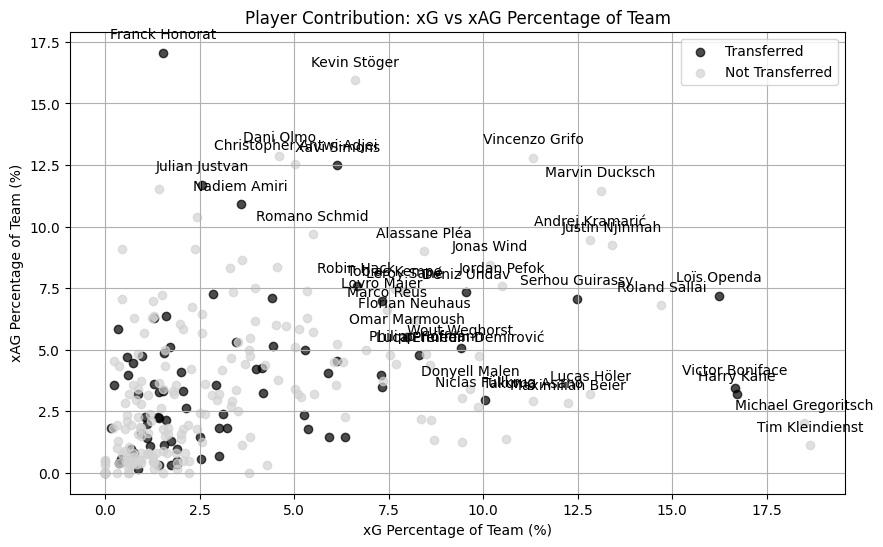

In [14]:


df['transfer_label'] = df['Player'].apply(lambda x: 'x' if x in df_2023_transfers['player_name'].values else 'o')
df = df[df['Min'] >= 1000]

plt.figure(figsize=(10, 6))

# Plot the points and use different markers based on transfer status
for label in ['x', 'o']:
    subset = df[df['transfer_label'] == label]
    color = 'black' if label == 'x' else 'lightgrey'
    plt.scatter(subset['xG_pct_of_team'], subset['xAG_pct_of_team'], 
                marker='o', color=color, 
                alpha=0.7, label=f'{"Transferred" if label == "x" else "Not Transferred"}')

# Step 3: Filter and label players where xG_pct_of_team + xAG_pct_of_team > 13
high_contributors = df[df['xG_pct_of_team'] + df['xAG_pct_of_team'] > 13]

# Annotate those players where xG_pct_of_team + xAG_pct_of_team > 13
for i, row in high_contributors.iterrows():
    plt.annotate(row['Player'], 
                 (row['xG_pct_of_team'], row['xAG_pct_of_team']),
                 textcoords="offset points", xytext=(0,10), ha='center')

# Step 4: Add labels and title
plt.xlabel('xG Percentage of Team (%)')
plt.ylabel('xAG Percentage of Team (%)')
plt.title('Player Contribution: xG vs xAG Percentage of Team')
plt.legend()
plt.grid(True)
plt.show()

Progressive Passes Completed per 100, vs Shots per 100 touches

In [16]:


# Sort the dataframe by the respective metrics
top_100_prp_cmp = df.nlargest(100, 'PrP_Cmp_100')  # Top 100 by 'PrP_Cmp_100'
top_5_prp_cmp = top_100_prp_cmp.nlargest(5, 'PrP_Cmp_100')  # Top 5 by 'PrP_Cmp_100'

top_100_sh_tch = df.nlargest(100, 'Sh_Tch_100')  # Top 100 by 'Sh_Tch_100'
top_20_sh_tch = top_100_sh_tch.nlargest(20, 'Sh_Tch_100')  # Top 5 by 'Sh_Tch_100'

top_100_sh_tch.head()



,Rk,season_id_x,competition_id,Player,Nation,Pos,Squad,Age,Born,MP,...,season,club_name,club_id,League_Position,season_id_y,team_xG,team_xAG,xG_pct_of_team,xAG_pct_of_team,transfer_label
218,219,2023,L1,Harry Kane,eng ENG,FW,Bayern Munich,30.0,1993.0,32,...,23/24,Bayern Munich,27,3,2023,5.80,6.24,16.724138,3.205128,x
341,342,2023,L1,Loïs Openda,be BEL,FW,RB Leipzig,23.0,2000.0,34,...,23/24,RB Leipzig,23826,4,2023,4.56,2.64,16.228070,7.196970,x
54,55,2023,L1,Victor Boniface,ng NGA,FW,Leverkusen,22.0,2000.0,23,...,23/24,Bayer 04 Leverkusen,15,1,2023,5.40,6.42,16.666667,3.426791,x
151,152,2023,L1,Michael Gregoritsch,at AUT,FW,Freiburg,29.0,1994.0,32,...,23/24,SC Freiburg,60,10,2023,2.65,2.50,18.490566,2.000000,o
407,408,2023,L1,Patrik Schick,cz CZE,FW,Leverkusen,27.0,1996.0,20,...,23/24,Bayer 04 Leverkusen,15,1,2023,5.40,6.42,9.444444,1.246106,o


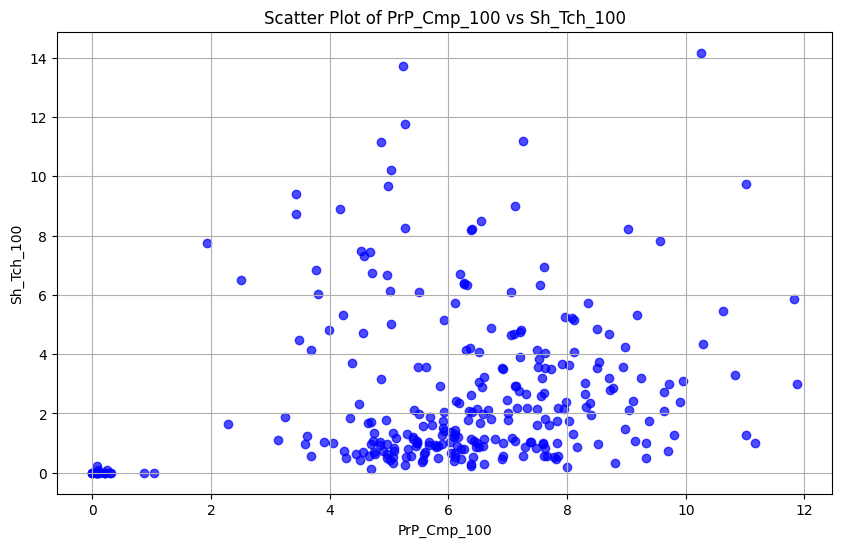

In [17]:

plt.figure(figsize=(10, 6))

# Scatter plot of 'PrP_Cmp_100' vs 'Sh_Tch_100'
plt.scatter(df['PrP_Cmp_100'], df['Sh_Tch_100'], color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('PrP_Cmp_100')
plt.ylabel('Sh_Tch_100')
plt.title('Scatter Plot of PrP_Cmp_100 vs Sh_Tch_100')

# Show plot
plt.grid(True)
plt.show()

In [44]:
top_100_sh_tch.columns

Index(['Rk', 'season_id_x', 'competition_id', 'Player', 'Nation', 'Pos',
       'Squad', 'Age', 'Born', 'MP', 'Starts', 'Min', '90s', 'PrgP', 'xG_90',
       'xAG_90', 'xG_xAG', 'Gls', 'Sh', 'Cmp', 'Touches', 'PrP_Cmp_100',
       'Sh_Tch_100', 'season', 'club_name', 'club_id', 'League_Position',
       'season_id_y', 'team_xG', 'team_xAG', 'xG_pct_of_team',
       'xAG_pct_of_team'],
      dtype='object')

In [75]:
transfers = query_db("SELECT * FROM transfers")
transfers_2023 = transfers[transfers['season_id'] == 2023]
df_stats_transfers = pd.merge(top_100_sh_tch, transfers_2023, left_on=['Player','season_id_x','club_name'], right_on=['player_name','season_id','to_club_name'], how='inner')

df_stats_transfers.head()
transfers_2023.columns

Index(['Unnamed: 0', 'transfer_id', 'transfer_date', 'transfer_type', 'season',
       'season_id', 'player_id', 'player_name', 'player_age_at_transfer',
       'transfer_fee_euro', 'transfer_fee_million', 'market_value_euro',
       'market_value_million', 'from_club_id', 'from_club_name',
       'from_competition_id', 'from_competition_name', 'to_club_id',
       'to_club_name', 'to_competition_id', 'to_competition_name',
       'date_of_birth_datetime', 'citizenship', 'position.main',
       'position.other', 'height_cm', 'foot', 'updated_at'],
      dtype='object')

In [77]:
print(transfers_2023[transfers_2023['player_name'] == 'Victor Boniface'])

      Unnamed: 0  transfer_id transfer_date  transfer_type season  season_id  \
2448        2448      4525081    22/07/2023  paid transfer  23/24       2023   

      player_id      player_name  player_age_at_transfer  transfer_fee_euro  \
2448     656681  Victor Boniface                    22.0         20500000.0   

      ...         to_club_name  to_competition_id  to_competition_name  \
2448  ...  Bayer 04 Leverkusen                 L1           Bundesliga   

      date_of_birth_datetime  citizenship   position.main position.other  \
2448              23/12/2000  ['Nigeria']  Centre-Forward           None   

      height_cm   foot                  updated_at  
2448      190.0  right  2024-02-25T15:00:01.128726  

[1 rows x 28 columns]


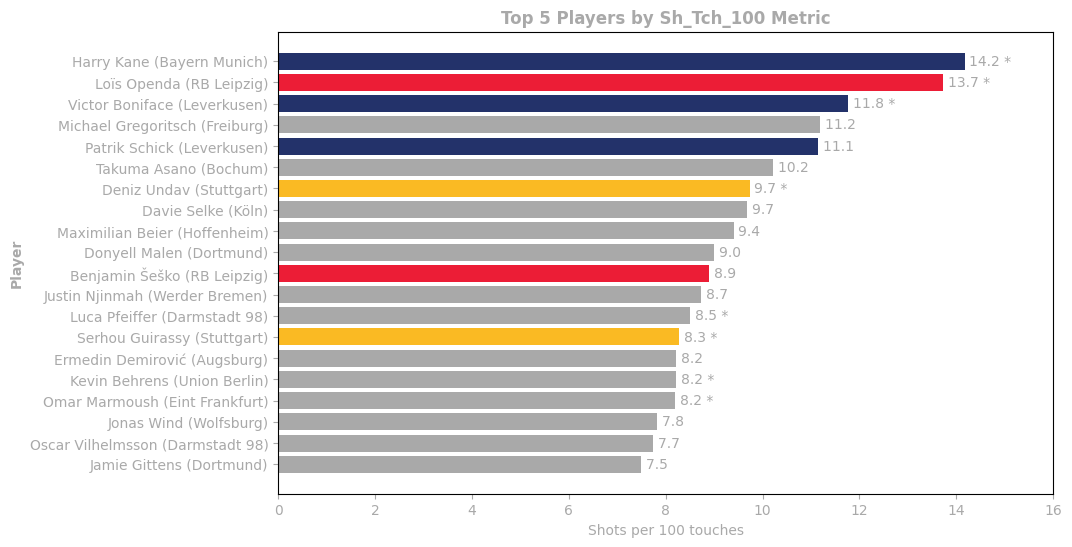

In [20]:

top_20_sh_tch['Player_Club'] = top_20_sh_tch.apply(lambda row: f"{row['Player']} ({row['Squad']})", axis=1)

# Set up the figure for plotting
plt.figure(figsize=(10, 6))

colors = []
for squad in top_20_sh_tch['Squad']:
    if squad == 'Stuttgart':
        colors.append('#FABA23')  # Fill color for VFB Stuttgart
    elif squad == 'RB Leipzig':
        colors.append('#EC1D36')  # Fill color for RB Leipzig
    elif squad == 'Bayern Munich':
        colors.append('#23326A')  # Fill color for RB Leipzig
    elif squad == 'Leverkusen':
        colors.append('#23326A')  # Fill color for RB Leipzig
    else:
        colors.append('darkgrey')  # Default color for other squads

# Make the bars thicker by adjusting the height parameter
bars = plt.barh(top_20_sh_tch['Player_Club'], top_20_sh_tch['Sh_Tch_100'], color=colors, height=0.8)

# Add labels and title
plt.xlabel('Shots per 100 touches', color='darkgrey')
plt.ylabel('Player', color='darkgrey', fontweight='bold')
plt.title('Top 5 Players by Sh_Tch_100 Metric', color='darkgrey', fontweight='bold')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.xlim(0, 16)

# Loop through bars to add text and asterisks where applicable
for i, bar in enumerate(bars):
    player_club = top_20_sh_tch['Player_Club'].iloc[i]  # Get the Player_Club text using index
    player = player_club.split(' (')[0]  # Extract the player's name

    # Check if the player was transferred in 2023
    transferred = df_2023_transfers[(df_2023_transfers['player_name'] == player) & (df_2023_transfers['season_id'] == 2023)]

    # Add value to the bar, and asterisk if applicable
    asterisk = '*' if not transferred.empty else ''  # Add asterisk if transferred
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.1f} {asterisk}', va='center', ha='left', color='darkgrey')

# Set the tick labels color
plt.gca().tick_params(axis='x', colors='darkgrey')
plt.gca().tick_params(axis='y', colors='darkgrey')

# Show the plot
plt.show()
